In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device, batch_data_by_country

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
import utils.results as results
import torch
import torch.nn as nn

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [2]:
TRAIN_PROPORTION = 0.9
PERIOD = 4  # Year to year prediction
device = get_device()

In [3]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [4]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_hf = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  #noisy_data_stds=[0.005, 0.05, 0.1], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

x_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
x_valid_t = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device)
x_hf_t = torch.tensor(x_hf, dtype=torch.float32).to(device)

print(all_gts['country'].unique())

X_train shape : (445, 180)
X_valid shape : (53, 180)
y_train shape : (445,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Smoothing model

In [5]:
preprocessor.dates_high_freq
preprocessor.country_high_freq

df_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': [x_hf[i] for i in range(len(x_hf))]
})

df_x_train = pd.DataFrame({
    'date': preprocessor.dates_train.copy(),
    'country': preprocessor.country_train.copy(),
    'data': [X_train[i].copy() for i in range(len(X_train))],
    'y_true': [y_train[i].copy() for i in range(len(y_train))]
})

df_hf['date'] = pd.to_datetime(df_hf['date'])
df_x_train['date'] = pd.to_datetime(df_x_train['date'])

Using cpu device


100%|██████████| 100/100 [00:03<00:00, 32.95it/s]


Final training loss: 0.01430443860590458
Final validation loss: 0.49029991030693054
Final validation R^2: 0.3482432113873717


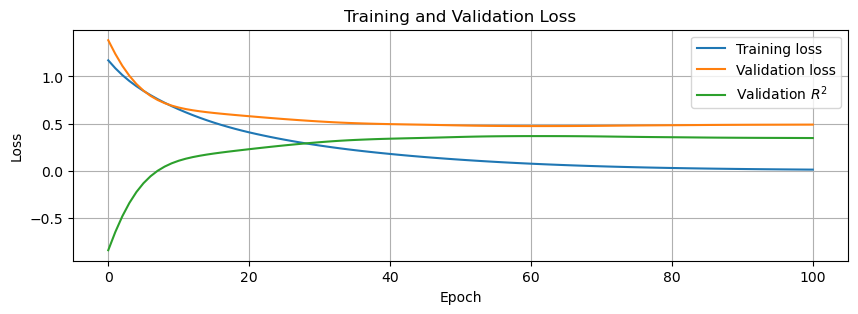

Basic R2 score: 0.3482432113873717


In [6]:
basic_model, basic_training_loss, basic_validation_loss, basic_validation_r_squared, basic_global_mse_losses = train_nn(X_train, 
                                                                        y_train, 
                                                                        X_valid, 
                                                                        y_valid, 
                                                                        num_epochs=100, 
                                                                        learning_rate=1e-4, 
                                                                        weight_decay=1e-2, 
                                                                        verbose=True,
                                                                        seed=SEED)

# Get the predictions
basic_y_pred_hf = basic_model(torch.tensor(x_hf, dtype=torch.float32).to(device)).clone().detach().cpu().numpy().squeeze()
basic_y_pred_lf = basic_model(torch.cat((x_train_t, x_valid_t), 0)).clone().detach().cpu().numpy().squeeze()
basic_r2_score = results.r2_score(y_valid, basic_model(x_valid_t).clone().detach().cpu().numpy().squeeze())

print(f"Basic R2 score: {basic_r2_score}")

### Case Study: Fourrier Transform Smoothing

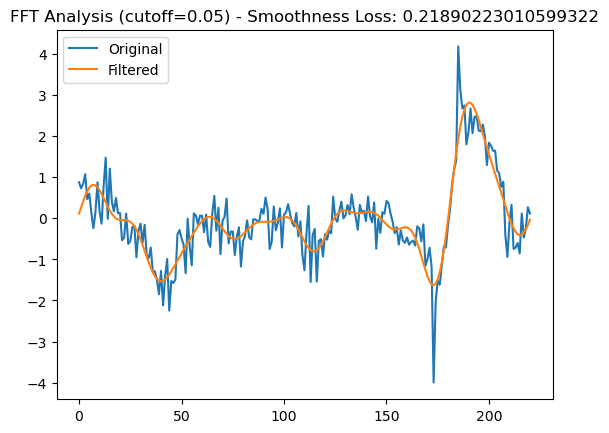

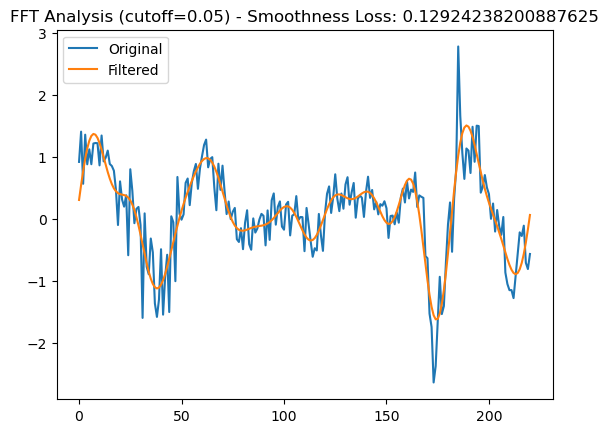

In [7]:
df_preds_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': [basic_y_pred_hf[i] for i in range(len(basic_y_pred_hf))] 
})

def fft_analysis(preds, cutoff=0.05): 
    fft = np.fft.fft(preds)
    freqs = np.fft.fftfreq(len(preds))

    filtered = np.copy(fft)
    filtered[np.abs(freqs) > cutoff] = 0

    y_filtered = np.fft.ifft(filtered).real

    smoothness_loss = np.linalg.norm(y_filtered - preds) ** 2 / len(preds)

    plt.plot(preds, label='Original')
    plt.plot(y_filtered, label='Filtered')
    plt.title(f"FFT Analysis (cutoff={cutoff}) - Smoothness Loss: {smoothness_loss}")
    plt.legend()
    plt.show()

# Per country
for country in df_preds_hf['country'].unique()[:2]:
    country_data = df_preds_hf[df_preds_hf['country'] == country]
    fft_analysis(country_data['data'].values)

In [8]:
def fourier_upsample(signal, upsample_factor):
    if upsample_factor < 1:
        raise ValueError("Upsample factor must be greater than 1.")
    
    # Original signal length
    N = len(signal)

    # Energy to 1
    # orig_energy = np.linalg.norm(signal)
    signal = signal
    
    # Compute the Fourier Transform of the signal
    fft_signal = np.fft.fft(signal) / np.sqrt(N)
    
    # High-pass filter the signal
    fft_freqs = np.fft.fftfreq(N)
    #fft_signal[np.abs(fft_freqs) > 0.15] = 0
    
    # Zero-pad the FFT to increase resolution
    pad_size = (upsample_factor - 1) * N // 2
    fft_signal_padded = np.concatenate([
        fft_signal[:N // 2],                # Low frequencies
        np.zeros(pad_size),                # Zero-padding
        fft_signal[N // 2:]                # High frequencies
    ])

    # Perform the Inverse FFT to return to the time domain
    upsampled_signal = np.fft.ifft(fft_signal_padded).real

    # Scale the result to adjust for energy conservation
    upsampled_signal *= np.sqrt(N) * upsample_factor

    
    return upsampled_signal

In [9]:
from scipy.signal import resample

In [10]:
def smooth_using_fft(signal, cutoff=0.1):
    fft_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal))

    fft_signal[np.abs(freqs) > cutoff] = 0

    return np.fft.ifft(fft_signal).real

def smooth_upsampled(signal, upsample_factor, cutoff=0.1):
    upsampled = resample(signal[:-1], upsample_factor * len(signal))
    upsampled = np.concatenate([upsampled, [signal[-1]]])

    if cutoff is None:
        return upsampled
    
    smoothed = smooth_using_fft(upsampled, cutoff)

    return smoothed

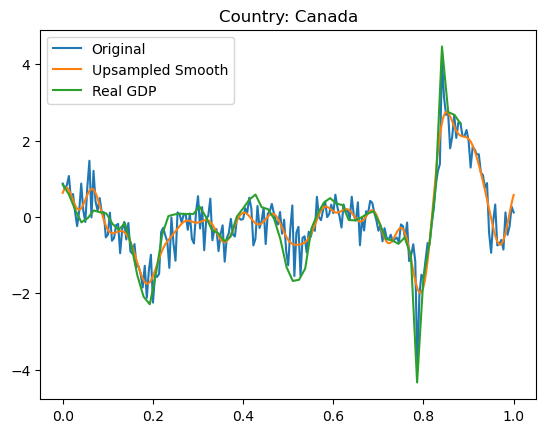

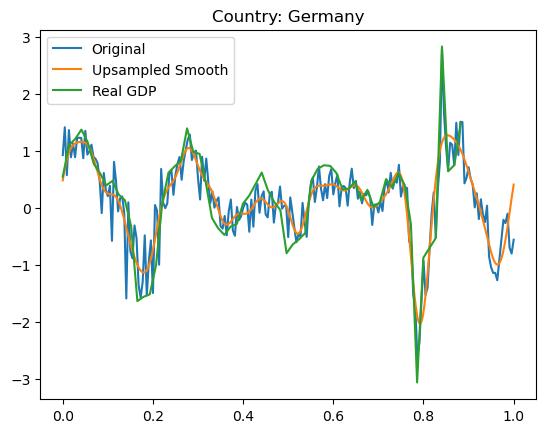

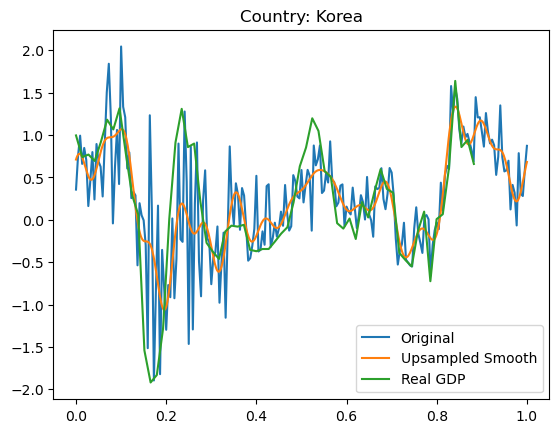

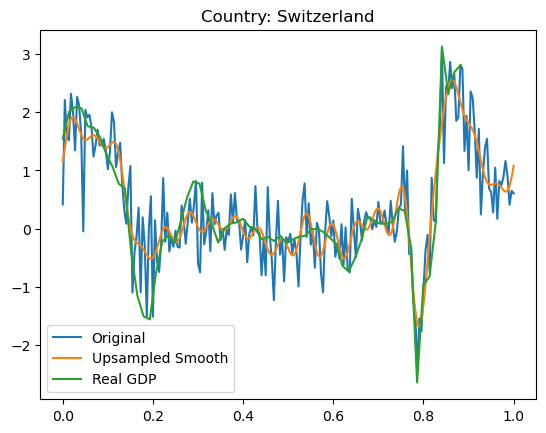

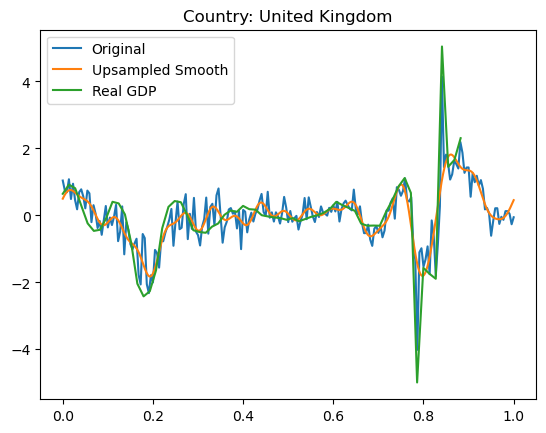

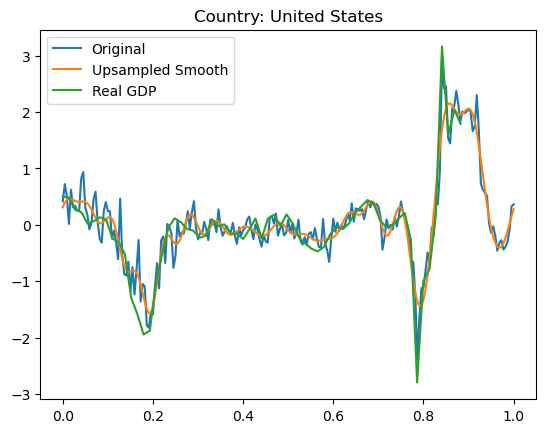

In [11]:
df_true_gdps = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'data': [y_train[i] for i in range(len(y_train))]
})

for country in df_preds_hf['country'].unique()[:]:
    if country == 'Japan':
        continue

    country_data = df_preds_hf[df_preds_hf['country'] == country]

    signal = country_data['data'].values    
    new_sig = smooth_upsampled(signal, 3, cutoff=0.03)

    x = np.linspace(0, 1, len(new_sig))
    orig_x = np.linspace(0, 1, len(country_data['data'].values))

    plt.plot(orig_x, country_data['data'].values, label='Original')
    plt.plot(x, new_sig, label='Upsampled Smooth')

    # Real gdps
    X_train_country = df_true_gdps[df_true_gdps['country'] == country]
    plt.plot(np.linspace(0, 3 * len(X_train_country['data']) / len(country_data['data'].values), len(X_train_country['data'])), X_train_country['data'], label='Real GDP')

    plt.legend()
    plt.title(f"Country: {country}")

    plt.show()

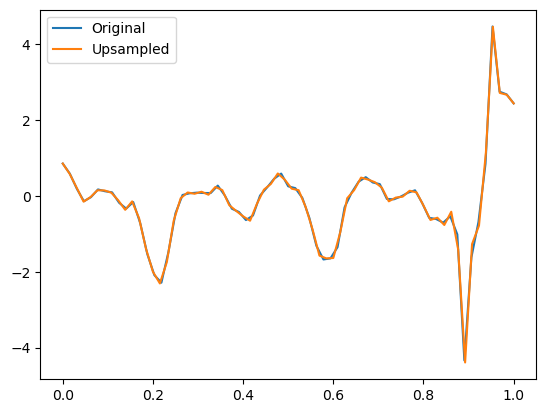

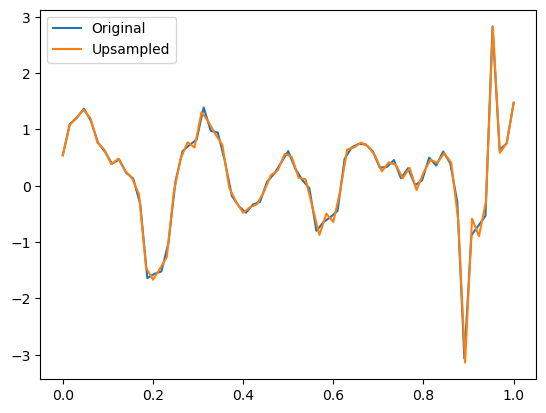

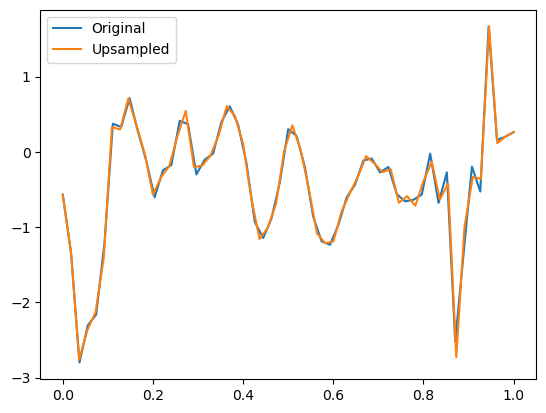

In [12]:
df_true_gdps = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'data': [y_train[i] for i in range(len(y_train))]
})

for country in df_preds_hf['country'].unique()[:3]:
    country_data = df_true_gdps[df_true_gdps['country'] == country]

    signal =  country_data['data'].values   
    new_sig = smooth_upsampled(signal, 1, cutoff=None)#0.2)

    x = np.linspace(0, 1, len(new_sig))
    orig_x = np.linspace(0, 1, len(country_data['data'].values))

    plt.plot(orig_x, country_data['data'].values, label='Original')
    plt.plot(x, new_sig, label='Upsampled')
    plt.legend()

    # Real gdps
    # X_train_country = df_true_gdps[df_true_gdps['country'] == country]
    # plt.plot(np.linspace(0, 3 * len(X_train_country['data']) / len(country_data['data'].values), len(X_train_country['data'])), X_train_country['data'], label='Real GDP')

    plt.show()